In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import pandas as pd

In [3]:
PATH = "data/competitions/dog-breed-identification"
#PATH = "data/competitions/dogs-vs-cats-redux-kernels-edition/"
sz=224
bs=48
arch=resnet50

In [9]:
!ls {PATH}/tmp
#!rm {PATH}/tmp/*.bc -r

340			 x_act_test_resnet50_0_224.bc
x_act_resnet50_0_224.bc  x_act_val_resnet50_0_224.bc


In [10]:
print(torch.cuda.is_available(), torch.backends.cudnn.enabled)

True True


In [35]:
imgs = os.listdir(f'{PATH}/train')

In [11]:
label_csv = f'{PATH}/labels.csv'

In [13]:
label_df = pd.read_csv(label_csv)
n = label_df.shape[0]
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [14]:
breeds = label_df.pivot_table(index='breed', aggfunc='count').sort_values('id', ascending=False)

In [16]:
val_idxs=get_cv_idxs(n)

In [18]:
np.save(f'{PATH}/tmp/val_idxs', val_idxs)

In [23]:
val_idxs = np.load(f'{PATH}/tmp/val_idxs.npy');

In [24]:
def get_model(sz, bs):
    tfms=tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data=ImageClassifierData.from_csv(PATH, 'train', 
                                  label_csv, tfms=tfms,bs=bs, 
                                  test_name='test', suffix='.jpg',
                                  val_idxs=val_idxs)
    return data if sz > 300 else data.resize(340, 'tmp')

In [26]:
data = get_model(sz, bs)
learn=ConvLearner.pretrained(arch, data, precompute=True)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [27]:
size_d = {name: PIL.Image.open(f'{PATH}/{name}').size for name in data.trn_ds.fnames}

In [56]:
x, y = list(zip(*size_d.values()))

In [70]:
row_sz = np.array([it[0] for it in list(size_d.values())])
col_sz = np.array([it[1] for it in list(size_d.values())])

(array([ 135.,  592., 1347., 1164., 4599.,  128.,   76.,   62.,   14.,   11.]),
 array([ 97. , 185.5, 274. , 362.5, 451. , 539.5, 628. , 716.5, 805. , 893.5, 982. ]),
 <a list of 10 Patch objects>)

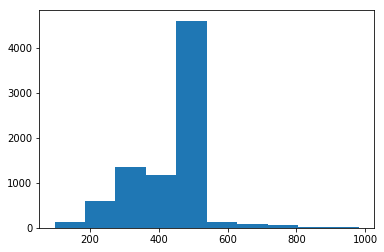

In [66]:
plt.hist(row_sz[row_sz<1000])

(array([ 235.,  733., 2205., 2979., 1807.,   98.,   27.,   33.,    7.,   10.]),
 array([102., 190., 278., 366., 454., 542., 630., 718., 806., 894., 982.]),
 <a list of 10 Patch objects>)

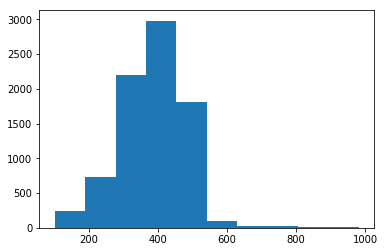

In [73]:
plt.hist(col_sz[col_sz<1000])

In [21]:
learn=ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

100%|██████████| 432/432 [00:40<00:00, 10.57it/s]


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 86%|████████▌ | 147/171 [00:03<00:00, 43.89it/s, loss=11.1]


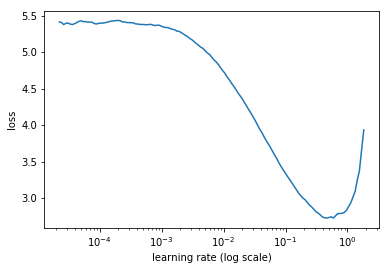

In [28]:
learn.lr_find()
learn.sched.plot()

In [29]:
learn.fit(1e-2, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.115558   0.584927   0.85472   
    1      0.607439   0.493976   0.855205                    
    2      0.439811   0.499208   0.861503                    



[0.49920762, 0.8615033210710038]

In [30]:
learn.save('resnet34-49-86-precomputed')

In [31]:
learn.load('resnet34-49-86-precomputed')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 78%|███████▊  | 134/171 [00:02<00:00, 50.00it/s, loss=1.39] 


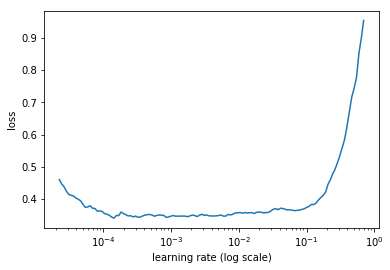

In [32]:
learn.lr_find()
learn.sched.plot()

In [33]:
learn.precompute = False
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.487381   0.427255   0.868909  
    1      0.441471   0.433465   0.860673                    
    2      0.425286   0.430922   0.866002                    



[0.4309224, 0.8660022158955418]

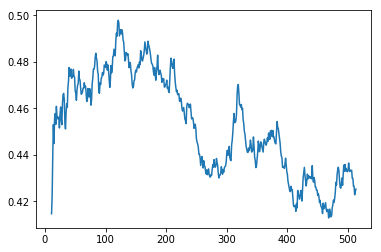

In [37]:
learn.sched.plot_loss()
#learn.sched.plot_lr()

In [34]:
learn.save('resnet34-43-86-cycle3')

In [87]:
learn.load('resnet34-43-86-cycle3')

In [38]:
learn.set_data(get_model(299,bs))

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [39]:
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.426773   0.412672   0.879291  
    1      0.405997   0.401485   0.883998                    
    2      0.377202   0.392423   0.875277                    



[0.39242306, 0.8752768566442091]

In [43]:
learn.save('resnet34-39-87-299px')

In [44]:
learn.load('resnet34-39-87-299px')

In [46]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.364081   0.397163   0.879637  
    1      0.351017   0.41393    0.867802                    
    2      0.309819   0.406499   0.872993                    
    3      0.331959   0.403275   0.873685                    
    4      0.294903   0.396299   0.877215                    
    5      0.263094   0.392558   0.881575                    
    6      0.226622   0.391131   0.879637                    



[0.39113143, 0.8796373189881791]

In [47]:
learn.save('resnet34-39-88')

In [48]:
learn.load('resnet34-39-88')

In [49]:
log_preds, y = learn.TTA()

TypeError: torch.max received an invalid combination of arguments - got (numpy.ndarray, dim=int), but expected one of:
 * (torch.FloatTensor source)
 * (torch.FloatTensor source, torch.FloatTensor other)
      didn't match because some of the keywords were incorrect: dim
 * (torch.FloatTensor source, int dim)
 * (torch.FloatTensor source, int dim, bool keepdim)


In [60]:
test_log_preds, test_y = learn.TTA(is_test=True)

In [61]:
probs = np.mean(np.exp(test_log_preds), 0)

array([[0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.     , 0.00002, 0.     , ..., 0.00028, 0.33121, 0.     ],
       ...,
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.     , 0.00002, 0.     , ..., 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.00001, ..., 0.     , 0.00001, 0.     ]], dtype=float32)

In [72]:
def extract_number(fname): return re.search('test/(\w*).jpg', fname).group(1)
ids = [extract_number(fname) for fname in data.test_ds.fnames]; ids

['de084b830010b6107215fef5d4a75b94',
 '6b423ca7020e70eb05732843c5d2bad1',
 '74aa7e201e0e93e13e87b986a7d31839',
 'a079f72193264bc5685e5d28d7372680',
 '583f7580fa5fec1266331fcf83b76fd6',
 '72cd7496a319c832f670fbb8d349217e',
 'ed9e75a553dbb4712addc1638693dc03',
 '6322fa7edb40af844609b4843a89b5fd',
 'd18de4f66f7d2ae8dffb08ec13b9bbc5',
 '8c567325012bf8d7daeff453ec959312',
 'bbecb2e61f07719abe32be3f36b3fac0',
 '7d3a1066521da895f915af31e8e739df',
 'a0256a9577f2e7c6631dd78556e4bab8',
 '87dafc44ed8ae792ea5c341d7cbb6df4',
 '1f2e9080823a6b093e7a4baa668393d2',
 'c65172e587bf02794e5b40f830bcb2af',
 '4f0b2dbc23fdef5f939144f456a62140',
 'a5049952a1a2ea0473e6520db5e4a4fb',
 '685ac2356ad42163b2141a41972e5c54',
 'bd405393e16688e5282b57d92bdbb97b',
 'cbb4039e5a16f80c02f3d188f98beaf7',
 '18cf06b0c6a59c6891bf6f5a42bcc73d',
 '9ec769e34bc902bd9de458103e9347c8',
 '14dac63a8e92005b685c7d39ddd8ed40',
 'c5ebdbaf77a7d833edfde7061bbb21d8',
 '161b2a67618d2217940282d01d27c32a',
 '74b133bbc2d4ece626394bdec13d702a',
 

In [74]:
df_sub = pd.DataFrame(probs, index=ids, columns=data.classes); df_sub

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
de084b830010b6107215fef5d4a75b94,4.254412e-08,8.009516e-07,7.627926e-08,5.796154e-08,9.683630e-09,2.382415e-08,1.697998e-08,2.683758e-08,2.825168e-08,8.205732e-10,...,2.396129e-09,1.134383e-09,1.234120e-07,9.320241e-09,4.046466e-07,1.932646e-09,2.471984e-08,2.918288e-07,5.507995e-08,3.513611e-09
6b423ca7020e70eb05732843c5d2bad1,1.418594e-07,1.389126e-07,4.875447e-09,3.897616e-08,4.941207e-08,6.389344e-09,3.407498e-08,6.548754e-09,1.177859e-08,1.110779e-09,...,1.883938e-09,5.981967e-10,5.297077e-09,7.576373e-09,5.441619e-09,3.167569e-09,2.469510e-06,2.553406e-08,3.487057e-08,3.794731e-09
74aa7e201e0e93e13e87b986a7d31839,1.506912e-06,2.293019e-05,3.805962e-06,4.355276e-03,3.731946e-05,1.189437e-05,2.170045e-05,2.682765e-05,4.549212e-06,4.908850e-06,...,1.513425e-05,4.607602e-06,7.925939e-06,2.644843e-05,3.311623e-06,2.432144e-05,2.677285e-05,2.778700e-04,3.312138e-01,1.949648e-06
a079f72193264bc5685e5d28d7372680,2.224297e-04,5.068088e-05,1.290568e-05,2.285526e-05,2.365566e-06,1.321713e-06,4.219054e-05,1.322632e-06,2.320241e-06,1.168294e-06,...,6.286076e-06,3.423612e-06,5.503836e-06,4.466770e-07,2.345501e-05,9.867867e-06,1.276186e-04,3.661984e-06,6.485695e-04,3.997613e-04
583f7580fa5fec1266331fcf83b76fd6,5.992115e-08,8.064539e-09,9.244183e-09,1.670867e-07,3.814011e-09,4.567247e-09,2.771901e-10,3.149791e-10,5.253289e-10,1.255062e-10,...,1.928632e-08,2.336531e-10,1.551388e-10,5.188325e-10,3.106712e-09,1.088117e-09,2.991912e-10,1.044924e-08,2.152190e-08,2.883826e-10
72cd7496a319c832f670fbb8d349217e,2.446372e-05,1.396375e-06,1.785959e-06,2.778580e-06,1.599518e-04,3.078849e-06,4.334506e-06,1.526182e-05,3.868044e-05,1.162746e-04,...,1.032166e-05,2.235070e-05,5.765700e-03,2.971161e-04,1.235985e-03,2.494596e-06,1.040546e-05,7.584144e-06,4.400966e-07,2.573791e-05
ed9e75a553dbb4712addc1638693dc03,1.758173e-06,5.941250e-07,2.074912e-07,5.590356e-07,1.297549e-10,3.390787e-09,2.026926e-07,9.891358e-11,1.249934e-08,1.839580e-09,...,1.232960e-08,5.966175e-09,5.087756e-08,2.945719e-09,1.195234e-08,5.979683e-07,5.001273e-09,9.213469e-11,3.588735e-08,9.925741e-07
6322fa7edb40af844609b4843a89b5fd,2.786500e-09,9.211850e-10,1.758588e-09,4.517852e-10,1.731785e-09,3.998658e-09,1.340640e-08,2.490981e-08,1.250423e-09,3.119631e-08,...,9.299478e-09,1.825708e-08,9.999695e-01,4.417194e-08,5.083430e-07,2.152665e-10,1.010597e-10,1.369050e-09,1.705774e-10,7.629529e-08
d18de4f66f7d2ae8dffb08ec13b9bbc5,1.252772e-07,1.145170e-08,6.637324e-08,4.314577e-08,1.702754e-07,3.404712e-06,5.398229e-09,9.940788e-09,1.374803e-07,1.770464e-06,...,1.813410e-08,6.374289e-07,9.294746e-09,4.297849e-06,1.891684e-08,9.148646e-07,1.668282e-07,2.564478e-08,5.628534e-08,7.126173e-09
8c567325012bf8d7daeff453ec959312,3.533150e-06,7.397842e-07,1.608219e-06,2.762210e-07,3.240321e-05,4.241851e-03,2.173458e-07,2.836317e-05,1.176638e-05,1.489820e-05,...,3.345177e-06,1.043247e-06,1.219401e-06,5.688161e-05,5.162004e-06,4.748482e-06,5.230591e-07,1.118281e-06,6.497585e-06,7.464808e-07


In [77]:
df_sub.to_csv(f'{PATH}/submission_0.csv', index_label="id", float_format='%.7f')

In [78]:
!head {PATH}/submission_0.csv

id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,english_foxhound,english_setter,english_springer,entlebucher,eskimo_dog,flat-coated_retriever,french_bulldog,german_shepherd,german_short-haired_pointer,giant_schnauzer,golden_retriever,gordon_setter,great_dane,great_pyrenees,greater_swiss_mountain_dog,groenendael,ibizan_hound,irish_setter,irish_terrier,irish_water_spaniel,irish_wolfhound,italian_greyhound,japanese_spaniel,keeshond,kelpie,kerry_blue_terrier,komondor,kuvasz,labrador_retriever,lakeland_terrier,leonberg,lhasa,mala

In [64]:
df_sample = pd.read_csv(f'{PATH}/sample_submission.csv'); df_sample

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
5,00225dcd3e4d2410dd53239f95c0352f,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
6,002c2a3117c2193b4d26400ce431eebd,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
7,002c58d413a521ae8d1a5daeb35fc803,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
8,002f80396f1e3db687c5932d7978b196,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
9,0036c6bcec6031be9e62a257b1c3c442,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
